In [ ]:
# Sequence processing with convnets

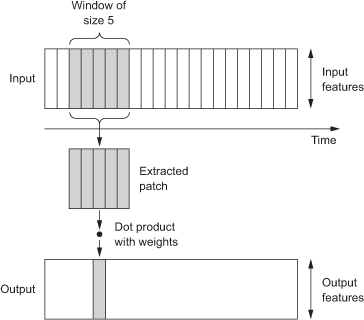

In [5]:
from keras.datasets import imdb
from keras.utils.data_utils import pad_sequences


max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

2022-08-22 12:44:20.678124: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 12:44:20.682315: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
/usr/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


157/157 [==============================] - 16s 94ms/step - loss: 0.7520 - acc: 0.5213 - val_loss: 0.6873 - val_acc: 0.5646
Epoch 2/10
157/157 [==============================] - 14s 92ms/step - loss: 0.6708 - acc: 0.6447 - val_loss: 0.6773 - val_acc: 0.5526
Epoch 3/10
157/157 [==============================] - 15s 97ms/step - loss: 0.6414 - acc: 0.7278 - val_loss: 0.6450 - val_acc: 0.6966
Epoch 4/10
157/157 [==============================] - 15s 94ms/step - loss: 0.5882 - acc: 0.7905 - val_loss: 0.5827 - val_acc: 0.6934
Epoch 5/10
157/157 [==============================] - 15s 93ms/step - loss: 0.4816 - acc: 0.8248 - val_loss: 0.4576 - val_acc: 0.8122
Epoch 6/10
157/157 [==============================] - 15s 93ms/step - loss: 0.3798 - acc: 0.8594 - val_loss: 0.4364 - val_acc: 0.8320
Epoch 7/10
157/157 [==============================] - 15s 93ms/step - loss: 0.3267 - acc: 0.8824 - val_loss: 0.4117 - val_acc: 0.8542
Epoch 8/10
157/157 [==============================] - 14s 90ms/step - los

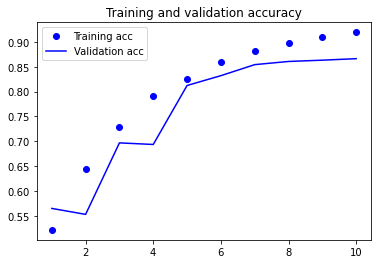

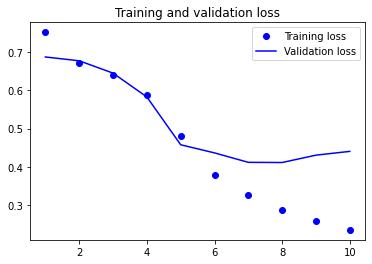

In [7]:
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Combining CNNs and RNNs to process long sequences

In [8]:
import os


data_dir = 'climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [9]:
import numpy as np


float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
val_steps = min(500, (300000 - 200001 - lookback))
test_steps = (len(float_data) - 300001 - lookback)

In [12]:
# Because 1D convnets process input patches independently, 
# they aren’t sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), 
# unlike RNNs. 
# Of course, to recognize longer-term patterns, you can stack many convolution layers and pooling layers, 
# resulting in upper layers that will see long chunks of the original inputs
# but that’s still a fairly weak way to induce order sensitivity.

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/tmp/ipykernel_242078/4162765681.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 52s 103ms/step - loss: 0.4182 - val_loss: 0.4516
Epoch 2/20
500/500 [==============================] - 53s 105ms/step - loss: 0.3608 - val_loss: 0.4579
Epoch 3/20
500/500 [==============================] - 51s 101ms/step - loss: 0.3372 - val_loss: 0.4562
Epoch 4/20
500/500 [==============================] - 51s 102ms/step - loss: 0.3192 - val_loss: 0.4773
Epoch 5/20
500/500 [==============================] - 51s 103ms/step - loss: 0.3092 - val_loss: 0.5078
Epoch 6/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3001 - val_loss: 0.4563
Epoch 7/20
500/500 [==============================] - 51s 101ms/step - loss: 0.2929 - val_loss: 0.4814
Epoch 8/20
500/500 [==============================] - 52s 104ms/step - loss: 0.2847 - val_loss: 0.4932
Epoch 9/20
500/500 [==============================] - 53s 106ms/step - loss: 0.2781 - val_loss: 0.4954
Epoch 10/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2756 

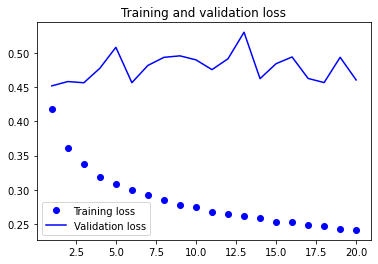

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs 
# is to use a 1D convnet as a preprocessing step before an RNN 

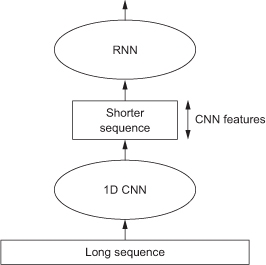

In [14]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [15]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

/tmp/ipykernel_242078/1588410458.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 162s 321ms/step - loss: 0.3271 - val_loss: 0.2904
Epoch 2/20
500/500 [==============================] - 162s 325ms/step - loss: 0.2928 - val_loss: 0.2753
Epoch 3/20
500/500 [==============================] - 163s 327ms/step - loss: 0.2793 - val_loss: 0.2709
Epoch 4/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2715 - val_loss: 0.2947
Epoch 5/20
500/500 [==============================] - 161s 321ms/step - loss: 0.2655 - val_loss: 0.2986
Epoch 6/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2592 - val_loss: 0.2912
Epoch 7/20
500/500 [==============================] - 158s 316ms/step - loss: 0.2529 - val_loss: 0.2859
Epoch 8/20
500/500 [==============================] - 150s 300ms/step - loss: 0.2466 - val_loss: 0.2865
Epoch 9/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2418 - val_loss: 0.2994
Epoch 10/20
500/500 [==============================] - 157s 314ms/step - lo

In [ ]:
# Judging from the validation loss, 
# this setup isn’t as good as the regularized GRU alone,
# but it’s significantly faster. 
# It looks at twice as much data, 
# which in this case doesn’t appear to be hugely helpful but may be important for other datasets.

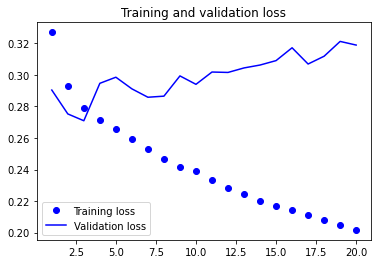

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()